In [1]:
import sys
sys.path.append("../..")
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import matplotlib
import os
from surgeNN import io

In [15]:
def get_true_sequence_lens(a): #get sequence length of True's in a boolean array
    # Convert to array
    a = np.asarray(a)

    # Attach sentients on either sides w.r.t True
    b = np.r_[False,a,False]

    # Get indices of group shifts
    s = np.flatnonzero(b[:-1]!=b[1:])

    # Get group lengths and hence the max index group
    m = np.array(s[1::2]-s[::2])

    return m

def get_number_of_runs_with_max_stagnant_loss(ds,patience):
    not_lower = ((ds.val_loss != ds.val_loss.rolling(e=patience+1,min_periods=1).min()) & np.isfinite(ds.val_loss))
    n_max_stagnant = np.zeros(len(ds.tg))
    
    for t,tg in enumerate(ds.tg):
        for i in ds.i:
            for it in ds.it:
                true_seq_lens = get_true_sequence_lens(not_lower.sel(tg=tg,it=it,i=i)) #get lengths of series of stagnant (=not decreasing) val_loss
                n_max_stagnant[t] += (np.sum(true_seq_lens == patience-1)>0) #if current it & i combination had a series of stagnant losses with length patience minus 1
    return n_max_stagnant

In [3]:
#configure the script
tgs        = ['stavanger-svg-nor-nhs.csv','wick-wic-gbr-bodc.csv','esbjerg-esb-dnk-dmi.csv','immingham-imm-gbr-bodc.csv','den_helder-denhdr-nld-rws.csv', 'fishguard-fis-gbr-bodc.csv',  'brest-822a-fra-uhslc.csv', 'vigo-vigo-esp-ieo.csv',  'alicante_i_outer_harbour-alio-esp-da_mm.csv']
tgnames = ['Stavanger (NOR)','Wick (UK)', 'Esbjerg (DK)','Immingham (UK)','Den Helder (NL)','Fishguard (UK)','Brest (FR)','Vigo (PT)', 'Alicante (SP)']

qnts = np.array([.95,.98,.99,.995]) #quantiles, don't touch

max_timesteps_between_extremes = 3

In [5]:
lstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/lstm')
lstms.open_performance_data(tgs)
lstms.data = lstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

#compute metrics for observations (it,i doesn't matter as long as all models have been run with the same n_t)
observed_thresholds = lstms.observed_thresholds()
observed_stds = lstms.observed_stds()

lstms=lstms.data

convlstms = io.Output('gs://leap-persistent/timh37/surgeNN_output/nns/performance_modified/convlstm')
convlstms.open_performance_data(tgs)
convlstms = convlstms.data.sel(max_timesteps_between_extremes=max_timesteps_between_extremes).load()

Find the fraction of runs for each tide gauge that had 1 or more consecutive series of patience-1 epochs without further decreases in the val_loss

In [17]:
get_number_of_runs_with_max_stagnant_loss(lstms,10)/(len(lstms.it)*len(lstms.i))

array([0.05833333, 0.18333333, 0.125     , 0.13333333, 0.11666667,
       0.16666667, 0.125     , 0.04166667, 0.04166667])

In [18]:
get_number_of_runs_with_max_stagnant_loss(convlstms,10)/(len(convlstms.it)*len(convlstms.i))

array([0.3       , 0.26666667, 0.1       , 0.13333333, 0.36666667,
       0.3       , 0.2       , 0.06666667, 0.16666667])

Find the fraction of runs for each tide gauge for which the maximum number of epochs were used for training:

In [23]:
(np.isfinite(lstms.val_loss).sum(dim='e')==len(lstms.e)).sum(dim=('i','it')).values/(len(lstms.i)*len(lstms.it))

array([0.        , 0.03333333, 0.04166667, 0.25833333, 0.175     ,
       0.00833333, 0.05      , 0.        , 0.        ])

In [24]:
(np.isfinite(convlstms.val_loss).sum(dim='e')==len(convlstms.e)).sum(dim=('i','it')).values/(len(convlstms.i)*len(convlstms.it)) #most ==100 is brest, try to rerun with 150 iterations for this

array([0.03333333, 0.03333333, 0.        , 0.13333333, 0.06666667,
       0.        , 0.23333333, 0.        , 0.        ])

Plot validation v.s. test performance as a function of the dropout rate:

Text(0.5, 0.98, 'convlstms RMSE')

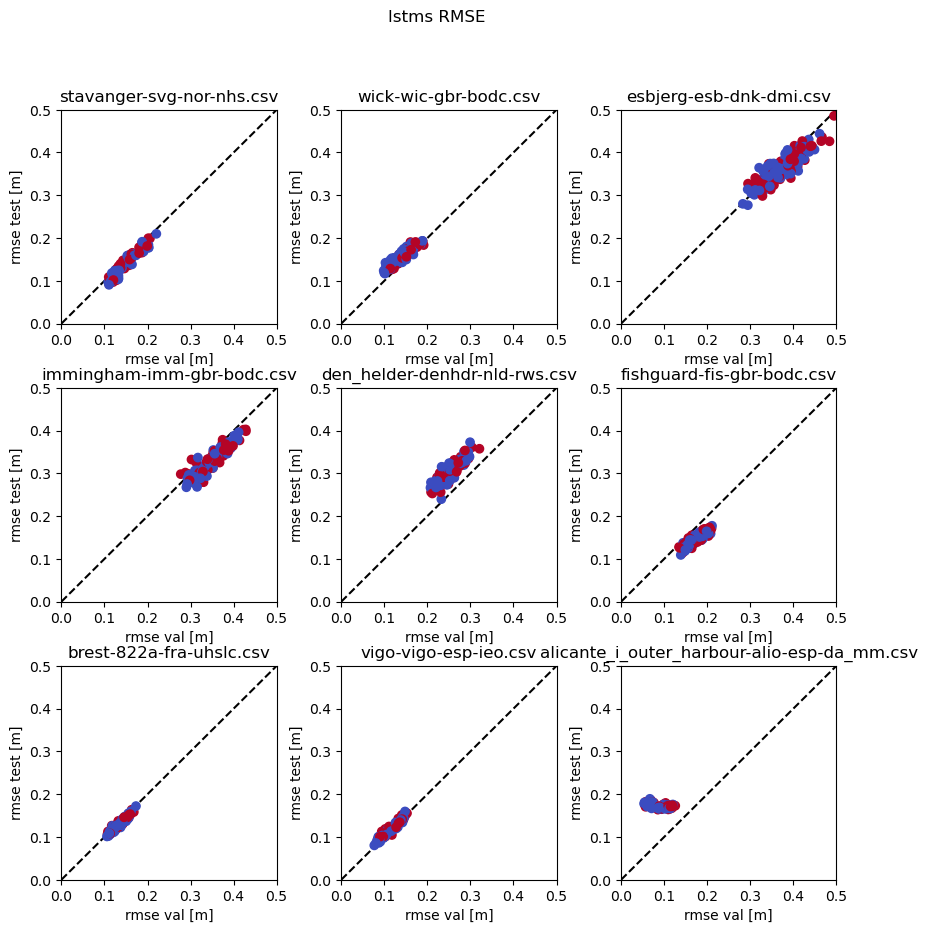

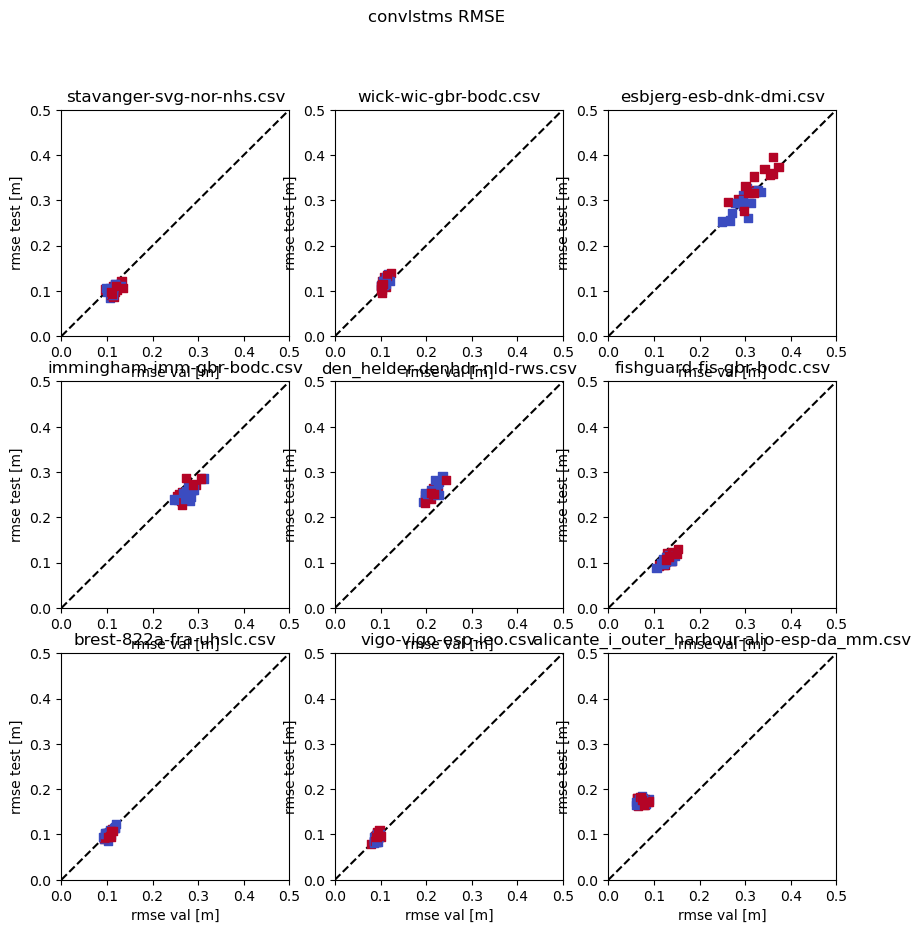

In [42]:
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(lstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   lstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=lstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm')
        
        ax.set_title(lstms.tg.values[tg])
        ax.plot([0,.5],[0,.5],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,.5)
        ax.set_xlabel('rmse val [m]')
        ax.set_ylim(0,.5)
        ax.set_ylabel('rmse test [m]')
        
plt.suptitle('lstms RMSE')
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(convlstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   convlstms.rmse_extremes.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=convlstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',marker='s')
        
        
        ax.set_title(convlstms.tg.values[tg])
        ax.plot([0,.5],[0,.5],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,.5)
        ax.set_xlabel('rmse val [m]')
        ax.set_ylim(0,.5)
        ax.set_ylabel('rmse test [m]')
        
plt.suptitle('convlstms RMSE')   

Text(0.5, 0.98, 'convlstms F1')

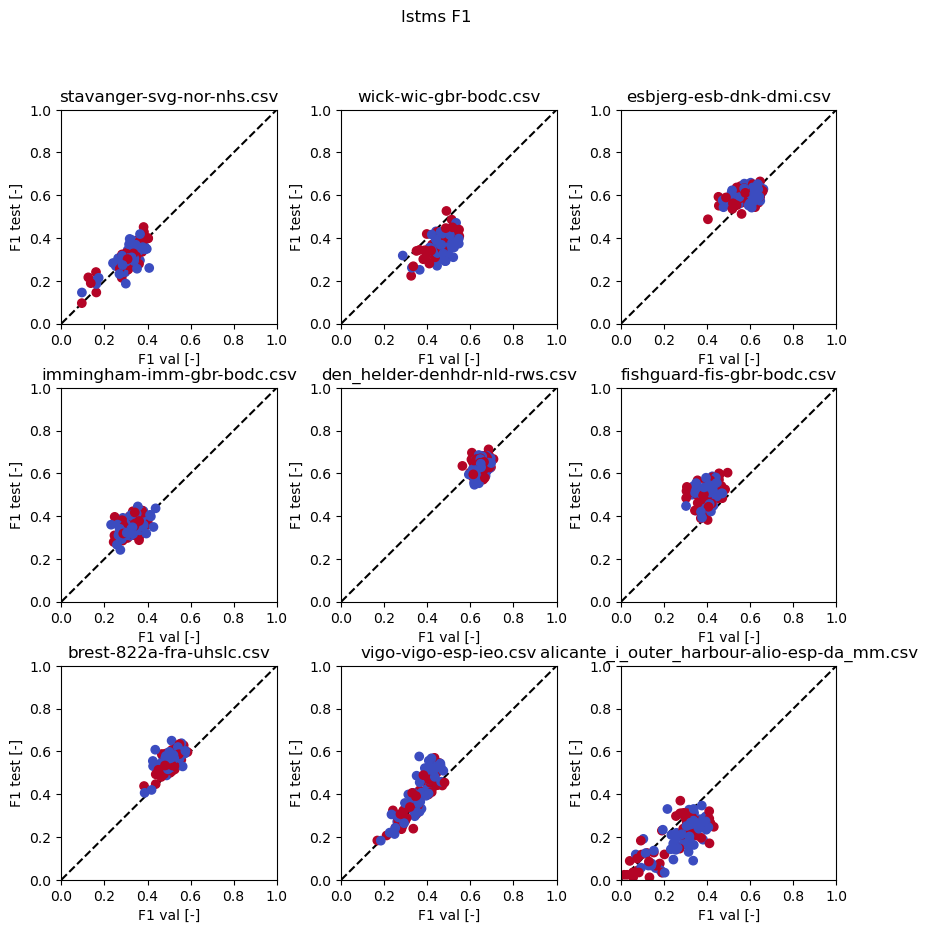

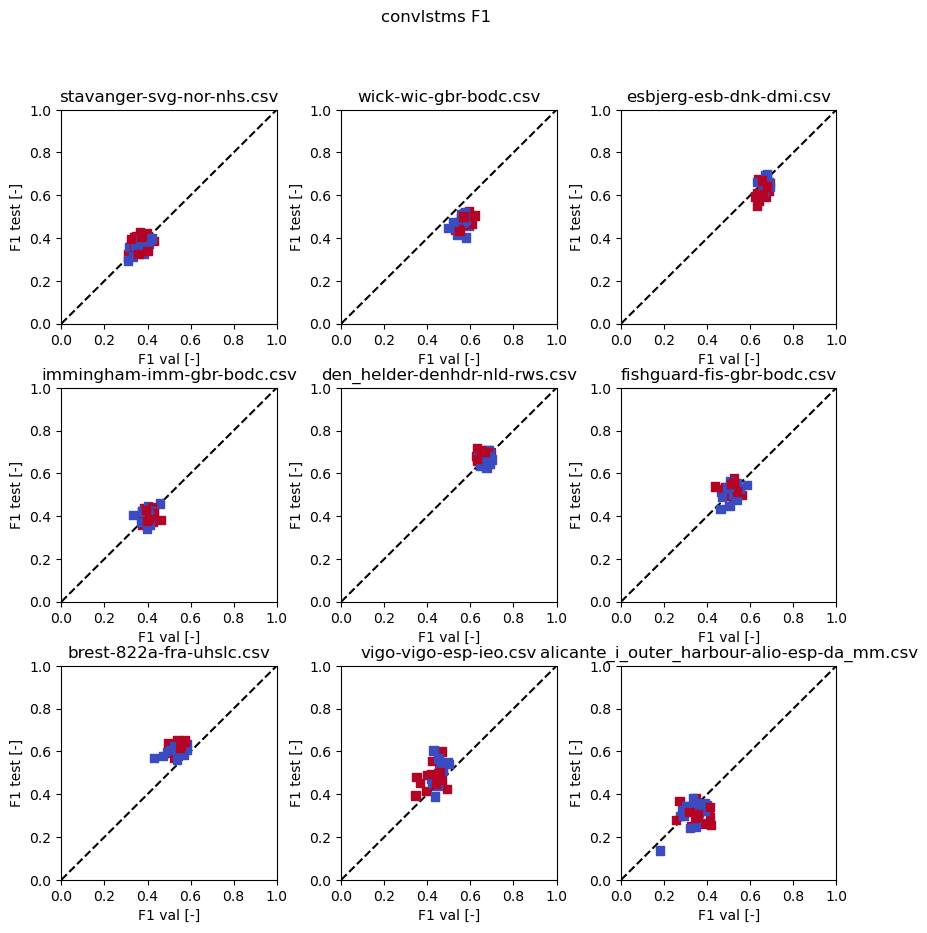

In [46]:
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(lstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   lstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=lstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm')
        
        ax.set_title(lstms.tg.values[tg])
        ax.plot([0,1],[0,1],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,1)
        ax.set_xlabel('F1 val [-]')
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 test [-]')
        
plt.suptitle('lstms F1')
fig=plt.figure(figsize=(10,10)) 
gs = fig.add_gridspec(3,3) #1 row, 3 columns
gs.update(wspace=.3)
gs.update(hspace=.3)
for tg in range(9):
        ax = plt.subplot(gs[np.unravel_index(tg,(3,3))]) 
        
        ax.scatter(convlstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='val').stack(i_it=['i','it']),
                   convlstms.f1.sel(quantile=.99).isel(tg=tg).sel(split='test').stack(i_it=['i','it']),c=convlstms.hyperparameters.sel(p='dropout').isel(tg=2).sel(split='test').stack(i_it=['i','it']),cmap='coolwarm',marker='s')
        
        
        ax.set_title(convlstms.tg.values[tg])
        ax.plot([0,1],[0,1],linestyle='dashed',color='black',zorder=0)
        ax.set_xlim(0,1)
        ax.set_xlabel('F1 val [-]')
        ax.set_ylim(0,1)
        ax.set_ylabel('F1 test [-]')
        
plt.suptitle('convlstms F1')   
